In [1]:
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Input, BatchNormalization

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2023-06-08 13:52:50.099870: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 13:52:50.393191: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 13:52:50.394142: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 13:52:51.328185: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
edges = pd.read_csv("dataset/elliptic_txs_edgelist.csv")
features = pd.read_csv("dataset/elliptic_txs_features.csv",header=None)
classes = pd.read_csv("dataset/elliptic_txs_classes.csv")

In [3]:
features.rename(columns = {0:'txId1'}, inplace = True)
features = pd.merge(features, edges.groupby('txId1').count(), on="txId1", how="left")
features.head()

,txId1,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,txId2
0,230425980,1,-0.056189,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133295,...,-0.582752,1.442895,1.440189,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,1.0
1,5530458,1,-0.056193,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133311,...,0.702410,-1.033609,-1.032884,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,1.0
2,232022460,1,-0.056378,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133972,...,0.467009,-1.033609,-1.032884,-0.106566,-0.113936,-0.135784,-0.186659,-0.102834,-0.102128,2.0
3,232438397,1,0.043005,0.743641,-0.644127,2.874647,-0.068726,2.304311,3.142835,-0.134902,...,-0.595477,0.204643,0.203652,0.994235,0.099367,-0.135784,0.669253,-0.102834,-0.102128,1.0
4,230460314,1,0.294595,-0.131268,-1.185821,0.125213,0.375512,0.188604,-0.101009,-0.134776,...,-0.380435,0.484856,0.546219,0.003514,0.312670,0.369103,1.281230,0.201809,0.202687,8.0


In [4]:
y = classes[classes['class'] != 'unknown']
x = features[features.iloc[:, 0].isin(y['txId'])]
x = x.iloc[:, 2:]
x.fillna(0, inplace=True)
y['class']=y['class'].apply(lambda x: x=='1')
y = y.iloc[:, 1]
x_train, x_test, y_train, y_test= train_test_split(x,y)
y_train.head()

/tmp/ipykernel_5030/595410248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['class']=y['class'].apply(lambda x: x=='1')


161937    False
15943     False
100944    False
115358    False
66506      True
Name: class, dtype: bool

In [5]:
x_train['txId2']=x_train['txId2'].apply(lambda x: np.log(1+x))
x_train.head()

,2,3,4,5,6,7,8,9,10,11,...,158,159,160,161,162,163,164,165,166,txId2
161937,-0.014834,0.560375,0.980956,-0.021424,0.242240,0.000076,-0.101009,-0.134768,-0.052280,0.069626,...,0.469130,-0.042018,0.422646,-0.106566,0.717947,0.613923,0.292652,-0.353559,-0.300689,1.098612
15943,-0.056356,-0.175567,-1.185821,-0.168061,-0.046514,-0.146557,-0.101009,-0.134568,-0.089026,-0.023656,...,-0.468233,1.442895,1.440189,-0.106566,-0.092606,-0.084494,-0.143864,-1.775510,-1.775746,0.693147
100944,-0.054793,-0.164493,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.128295,-0.085737,-0.024475,...,-0.582752,0.204643,0.203652,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,1.098612
115358,-0.053710,-0.158698,0.980956,-0.186390,-0.046514,-0.167505,-0.101009,-0.124416,-0.083587,-0.024475,...,-0.487319,-1.033609,-1.032884,-0.106566,-0.092606,-0.084494,-0.143864,1.569841,1.571490,1.098612
66506,-0.056363,-0.164493,-1.185821,-0.186390,-0.068726,-0.167505,-0.101009,-0.133917,-0.088853,-0.024475,...,0.193435,0.204643,0.203652,-0.106566,-0.113936,-0.135784,-0.186659,-0.102834,-0.102128,0.693147


(array([4.6556e+04, 4.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,  47.2,  94.4, 141.6, 188.8, 236. , 283.2, 330.4, 377.6,
        424.8, 472. ]),
 <BarContainer object of 10 artists>)

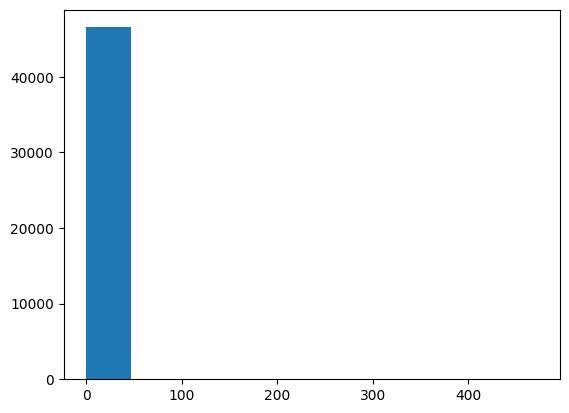

In [6]:
plt.hist(x['txId2'])

(array([8.8440e+03, 2.4615e+04, 9.9700e+02, 3.1700e+02, 1.1900e+02,
        2.3000e+01, 3.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.        , 0.61590954, 1.23181908, 1.84772862, 2.46363816,
        3.07954769, 3.69545723, 4.31136677, 4.92727631, 5.54318585,
        6.15909539]),
 <BarContainer object of 10 artists>)

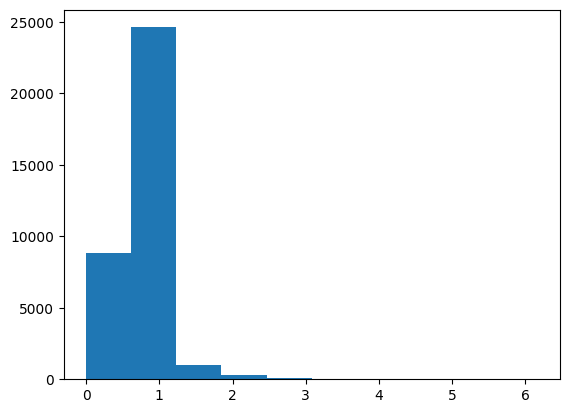

In [7]:
plt.hist(x_train['txId2'])

In [8]:
def create_test_model(metric):
  return_data = {
      "metric": metric,
      "loss": 0,
      "metric_result": 0,
      "ratio": 0
  }
  model = Sequential()

  model.add(LSTM(64, input_shape=(x_train.shape[1], 1)))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss=['binary_crossentropy'] , optimizer='adam', metrics=[metric])

  print("Training model with metric: ", metric)
  model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

  print("Evaluating model with metric: ", metric)
  loss, metric2 = model.evaluate(x_test, y_test)
  return_data["loss"] = loss
  return_data["metric_result"] = metric2

  y = classes[classes['class'] == 'unknown']
  x = features[features.iloc[:, 0].isin(y['txId'])]
  x = x.iloc[:, 2:]
  x.fillna(0, inplace=True)
  x['txId2']=x['txId2'].apply(lambda x: np.log(1+x))

  print("Predicting on model with metric: ", metric)
  result=model.predict(x)

  res=np.round(result)
  unique, counts = np.unique(res, return_counts=True)

  return_data["ratio"] = counts[1]/counts[0]
  print("Ratio for model with metric ", metric, " is :", return_data["ratio"])
  return return_data

In [ ]:
AUC_model = create_test_model("AUC")

Training model with metric:  AUC
Epoch 1/5
1092/1092 [==============================] - 15s 11ms/step - loss: 0.2969 - auc: 0.7035 - val_loss: 0.2302 - val_auc: 0.8648
Epoch 2/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.2455 - auc: 0.8129 - val_loss: 0.2540 - val_auc: 0.8177
Epoch 3/5
1092/1092 [==============================] - 12s 11ms/step - loss: 0.2052 - auc: 0.8557 - val_loss: 0.2075 - val_auc: 0.8515
Epoch 4/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.1909 - auc: 0.8787 - val_loss: 0.1725 - val_auc: 0.9186
Epoch 5/5
1092/1092 [==============================] - 16s 14ms/step - loss: 0.1629 - auc: 0.9171 - val_loss: 0.1558 - val_auc: 0.9343
Evaluating model with metric:  AUC
364/364 [==============================] - 2s 5ms/step - loss: 0.1558 - auc: 0.9343
Predicting on model with metric:  AUC
4913/4913 [==============================] - 20s 4ms/step
Ratio for model with metric  AUC  is : 0.035401435816373575


In [ ]:
Accuracy_model = create_test_model("Accuracy")

Training model with metric:  Accuracy
Epoch 1/5
1092/1092 [==============================] - 18s 14ms/step - loss: 0.3081 - Accuracy: 0.9026 - val_loss: 0.2981 - val_Accuracy: 0.9004
Epoch 2/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.2760 - Accuracy: 0.9035 - val_loss: 0.2311 - val_Accuracy: 0.9010
Epoch 3/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.1953 - Accuracy: 0.9322 - val_loss: 0.1781 - val_Accuracy: 0.9449
Epoch 4/5
1092/1092 [==============================] - 13s 12ms/step - loss: 0.1784 - Accuracy: 0.9426 - val_loss: 0.1995 - val_Accuracy: 0.9353
Epoch 5/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.1726 - Accuracy: 0.9463 - val_loss: 0.1579 - val_Accuracy: 0.9514
Evaluating model with metric:  Accuracy
364/364 [==============================] - 2s 5ms/step - loss: 0.1579 - Accuracy: 0.9514
Predicting on model with metric:  Accuracy
4913/4913 [==============================] - 20s 4ms/step
Ratio f

In [ ]:
Poisson_model = create_test_model("Poisson")

Training model with metric:  Poisson
Epoch 1/5
1092/1092 [==============================] - 15s 11ms/step - loss: 0.3076 - poisson: 0.3128 - val_loss: 0.3000 - val_poisson: 0.3072
Epoch 2/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.2394 - poisson: 0.2571 - val_loss: 0.1900 - val_poisson: 0.2223
Epoch 3/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.1809 - poisson: 0.2155 - val_loss: 0.1635 - val_poisson: 0.2063
Epoch 4/5
1092/1092 [==============================] - 14s 13ms/step - loss: 0.1595 - poisson: 0.2035 - val_loss: 0.1434 - val_poisson: 0.1962
Epoch 5/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.1623 - poisson: 0.2034 - val_loss: 0.1335 - val_poisson: 0.1877
Evaluating model with metric:  Poisson
364/364 [==============================] - 2s 6ms/step - loss: 0.1335 - poisson: 0.1877
Predicting on model with metric:  Poisson
4913/4913 [==============================] - 18s 4ms/step
Ratio for model with 

In [ ]:
Hinge_model = create_test_model("Hinge")

Training model with metric:  Hinge
Epoch 1/5
1092/1092 [==============================] - 15s 12ms/step - loss: 0.2971 - hinge: 1.0709 - val_loss: 0.3487 - val_hinge: 1.0505
Epoch 2/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.2385 - hinge: 1.0373 - val_loss: 0.1959 - val_hinge: 0.9970
Epoch 3/5
1092/1092 [==============================] - 12s 11ms/step - loss: 0.1896 - hinge: 1.0073 - val_loss: 0.1863 - val_hinge: 1.0002
Epoch 4/5
1092/1092 [==============================] - 12s 11ms/step - loss: 0.1860 - hinge: 1.0066 - val_loss: 0.1576 - val_hinge: 0.9931
Epoch 5/5
1092/1092 [==============================] - 12s 11ms/step - loss: 0.1806 - hinge: 1.0034 - val_loss: 0.1677 - val_hinge: 0.9903
Evaluating model with metric:  Hinge
364/364 [==============================] - 2s 6ms/step - loss: 0.1677 - hinge: 0.9903
Predicting on model with metric:  Hinge
4913/4913 [==============================] - 18s 4ms/step
Ratio for model with metric  Hinge  is : 0.067758

In [ ]:
Precision_model = create_test_model("Precision")

Training model with metric:  Precision
Epoch 1/5
1092/1092 [==============================] - 15s 12ms/step - loss: 0.3074 - precision: 0.0676 - val_loss: 0.2727 - val_precision: 0.0000e+00
Epoch 2/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.2254 - precision: 0.6736 - val_loss: 0.2010 - val_precision: 0.8730
Epoch 3/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.1894 - precision: 0.7493 - val_loss: 0.1688 - val_precision: 0.8459
Epoch 4/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.1698 - precision: 0.7890 - val_loss: 0.1621 - val_precision: 0.8689
Epoch 5/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.1659 - precision: 0.8064 - val_loss: 0.1573 - val_precision: 0.7801
Evaluating model with metric:  Precision
364/364 [==============================] - 2s 7ms/step - loss: 0.1573 - precision: 0.7801
Predicting on model with metric:  Precision
4913/4913 [==============================] - 18

In [ ]:
TruePositives_model = create_test_model("TruePositives")

Training model with metric:  TruePositives
Epoch 1/5
1092/1092 [==============================] - 15s 11ms/step - loss: 0.3177 - true_positives: 0.0000e+00 - val_loss: 0.3133 - val_true_positives: 0.0000e+00
Epoch 2/5
1092/1092 [==============================] - 12s 11ms/step - loss: 0.2534 - true_positives: 541.0000 - val_loss: 0.2007 - val_true_positives: 234.0000
Epoch 3/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.2132 - true_positives: 1105.0000 - val_loss: 0.2021 - val_true_positives: 602.0000
Epoch 4/5
1092/1092 [==============================] - 11s 10ms/step - loss: 0.1979 - true_positives: 1670.0000 - val_loss: 0.2444 - val_true_positives: 0.0000e+00
Epoch 5/5
1092/1092 [==============================] - 12s 11ms/step - loss: 0.1863 - true_positives: 1809.0000 - val_loss: 0.2009 - val_true_positives: 266.0000
Evaluating model with metric:  TruePositives
364/364 [==============================] - 2s 5ms/step - loss: 0.2009 - true_positives: 266.0000
P

### Analiza SHAP dla modelu z metryką Precision

In [9]:
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], 1)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss=['binary_crossentropy'] , optimizer='adam', metrics=["Precision"])
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
loss, metric2 = model.evaluate(x_test, y_test)
result=model.predict(x)

Epoch 1/5


2023-06-08 13:53:13.569830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-08 13:53:13.570755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-08 13:53:13.571366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1091/1092 [============================>.] - ETA: 0s - loss: 0.3000 - precision: 0.5265

2023-06-08 13:54:09.909446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-08 13:54:09.910385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-08 13:54:09.911019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1092/1092 [==============================] - 62s 56ms/step - loss: 0.3000 - precision: 0.5265 - val_loss: 0.2735 - val_precision: 0.7303
Epoch 2/5
1092/1092 [==============================] - 60s 55ms/step - loss: 0.2078 - precision: 0.7355 - val_loss: 0.1844 - val_precision: 0.7090
Epoch 3/5
1092/1092 [==============================] - 59s 54ms/step - loss: 0.1753 - precision: 0.7854 - val_loss: 0.1582 - val_precision: 0.8901
Epoch 4/5
1092/1092 [==============================] - 61s 56ms/step - loss: 0.1572 - precision: 0.8296 - val_loss: 0.1472 - val_precision: 0.8720
Epoch 5/5
   5/1456 [..............................] - ETA: 20s 

2023-06-08 13:58:23.144057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-08 13:58:23.144916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-08 13:58:23.145563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1456/1456 [==============================] - 22s 15ms/step


In [10]:
import shap

/home/szch/Studia-Sync/Informatyka_Stosowana/Semestr 1/Sztuczne sieci neuronowe/projekt/env/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/szch/Studia-Sync/Informatyka_Stosowana/Semestr 1/Sztuczne sieci neuronowe/projekt/env/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/refer

In [11]:
explainer = shap.GradientExplainer(model, np.array(x_train).reshape(x_train.shape[0],x_train.shape[1],1))
shap_values = explainer(np.array(x_train).reshape(x_train.shape[0],x_train.shape[1],1))

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2023-06-08 13:58:53.531434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-08 13:58:53.532162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-08 13

In [17]:
explainer

In [28]:
def displayShap(meanPredicted, shapEnabled):
    for i in range(3):
        for v in range(2):
            ind=i+v*3
            if shapEnabled==1 and i==2 and v==1:
                dp=meanPredicted[i+v*3][5][0].values
                dp=dp.reshape(dp.shape[0], dp.shape[1])
                shap.summary_plot(dp, x_train,plot_type='bar')
                fig = shap.summary_plot(dp, x_train,feature_names=x_train.columns.tolist(), show=False)
                _, h = plt.gcf().get_size_inches()
                plt.gcf().set_size_inches(h*50, h)
                plt.show()

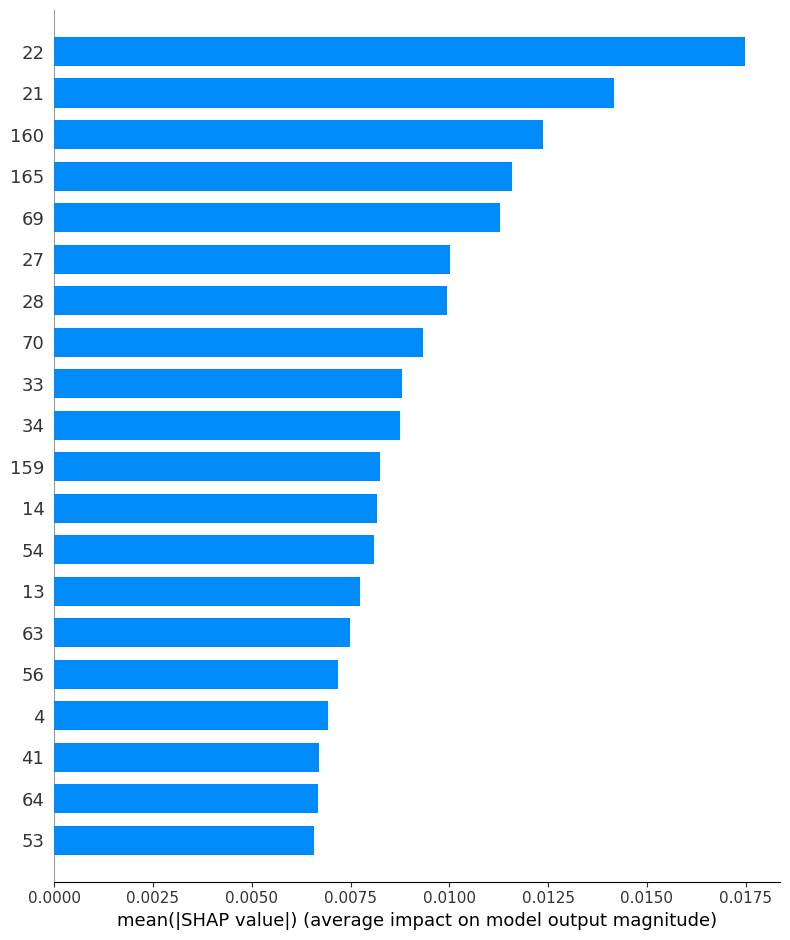

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


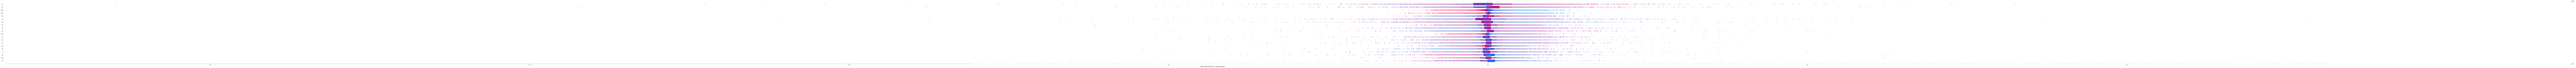

In [45]:
meanPredicted = [(1, 1, 1, 1, 1, shap_values)] * 6

displayShap(meanPredicted, 1)